In [1]:
import json 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os

RES_DIR = '/home/azureuser/cloudfiles/code/Users/SH/quant-experiments/eval-results'
RES_FOLDERS = [x for x in os.listdir(RES_DIR) if not x.__contains__('Phi')]
print(RES_FOLDERS)

# remove FP8 from the list
RES_FOLDERS.remove('FP8')

print(RES_FOLDERS)

['W8A8', 'FP8', 'W4A16', 'FP8_DYNAMIC', 'W8A16']
['W8A8', 'W4A16', 'FP8_DYNAMIC', 'W8A16']


In [2]:
def get_result_files(result_folder):
    res_files = []
    subfolders = os.listdir(os.path.join(RES_DIR, result_folder))
    for subfolder in subfolders:
        files = os.listdir(os.path.join(RES_DIR, result_folder, subfolder))
        # take the first file with .json extension
        for file in files:
            if file.endswith('.json'):
                res_files.append(os.path.join(RES_DIR, result_folder, subfolder, file))
                break
    
    return res_files

get_result_files(RES_FOLDERS[0])

['/home/azureuser/cloudfiles/code/Users/SH/quant-experiments/eval-results/W8A8/.__Phi-3.5-mini-instruct-W8A8/results_2024-11-14T14-01-33.812732.json',
 '/home/azureuser/cloudfiles/code/Users/SH/quant-experiments/eval-results/W8A8/.__Phi-3.5-mini-instruct-GPTQ-W8A8/results_2024-11-14T13-16-06.633317.json']

In [ ]:
def read_res_file(res_file):
    with open(res_file) as f:
        data = json.load(f)
    
    quantization_method = res_file.split('/')[-2].split('.__Phi-3.5-mini-instruct-')[1]
    
    return data, quantization_method

data,quantization_method = read_res_file(get_result_files(RES_FOLDERS[0])[1])
task_list = list(data['results'].keys())

print(task_list, quantization_method)


['gsm8k', 'hellaswag', 'lambada_openai', 'openbookqa', 'piqa', 'truthfulqa_mc1', 'winogrande'] GPTQ-W8A8


In [ ]:
task_metric_mapping = {}
for task in task_list:
    task_metric_mapping[task] = list(data['results'][task].keys())

all_res_files = []
for res_folder in RES_FOLDERS:
    all_res_files += get_result_files(res_folder)


{'gsm8k': ['alias', 'exact_match,strict-match', 'exact_match_stderr,strict-match', 'exact_match,flexible-extract', 'exact_match_stderr,flexible-extract'], 'hellaswag': ['alias', 'acc,none', 'acc_stderr,none', 'acc_norm,none', 'acc_norm_stderr,none'], 'lambada_openai': ['alias', 'perplexity,none', 'perplexity_stderr,none', 'acc,none', 'acc_stderr,none'], 'openbookqa': ['alias', 'acc,none', 'acc_stderr,none', 'acc_norm,none', 'acc_norm_stderr,none'], 'piqa': ['alias', 'acc,none', 'acc_stderr,none', 'acc_norm,none', 'acc_norm_stderr,none'], 'truthfulqa_mc1': ['alias', 'acc,none', 'acc_stderr,none'], 'winogrande': ['alias', 'acc,none', 'acc_stderr,none']}


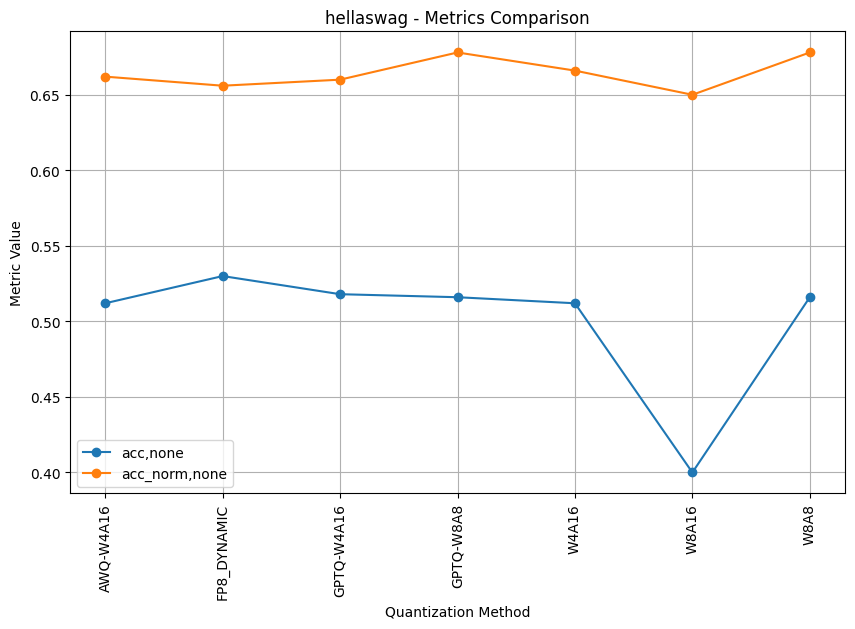

In [16]:
def plot_task_metrics(task):
    data, _ = read_res_file(all_res_files[-1])
    task_metric = data['results'][task]
    metrics = task_metric_mapping[task]

    # loop through all res files, record all different metrics for all quantization methods for the given task
    # create a separate plot for each metric, across all quantization methods
    # x-axis: quantization method, y-axis: metric value

    res_dict = {}
    for key in metrics:
        if key != 'alias':
            res_dict[key] = []

    for res_file in all_res_files:
        data, quantization_method = read_res_file(res_file)
        for metric in metrics:
            if metric != 'alias':
                res_dict[metric].append({'quantization_method': quantization_method, 'value': data['results'][task][metric]})

    metrics_to_care = list(res_dict.keys())
    metrics_to_care = list(filter(lambda x: not x.__contains__('stderr'), metrics_to_care))

    # create a separate plot for each metric
    plt.figure(figsize=(10, 6))
    for metric in metrics_to_care:
        df = pd.DataFrame(res_dict[metric])
        df = df.sort_values(by='quantization_method')
        plt.plot(df['quantization_method'], df['value'], marker='o', label=metric)

    plt.title(f'{task} - Metrics Comparison')
    plt.xlabel('Quantization Method')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_task_metrics('hellaswag')


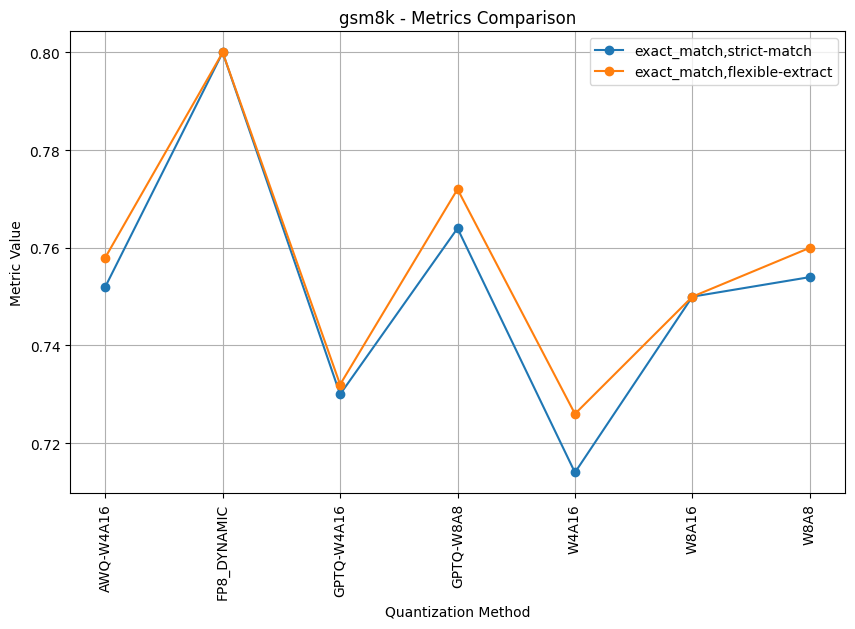

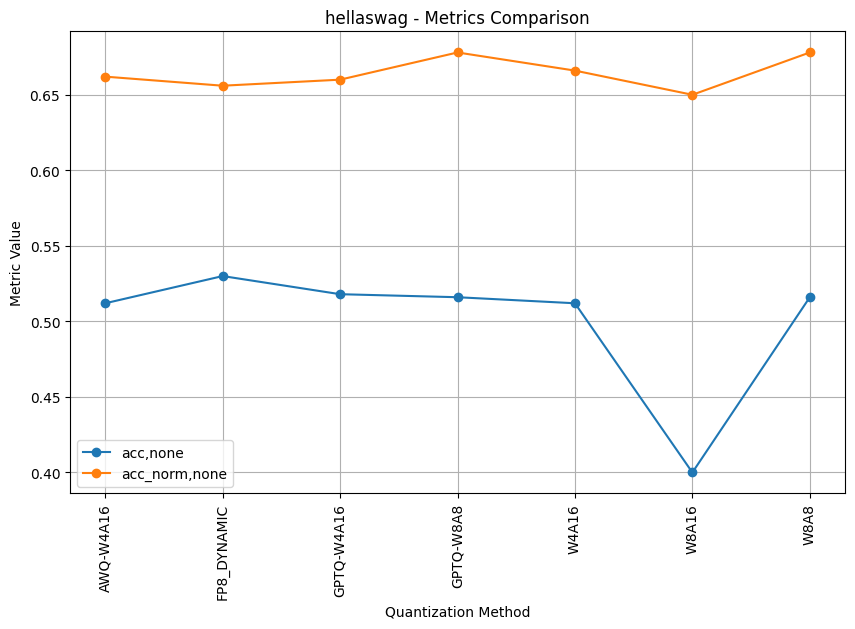

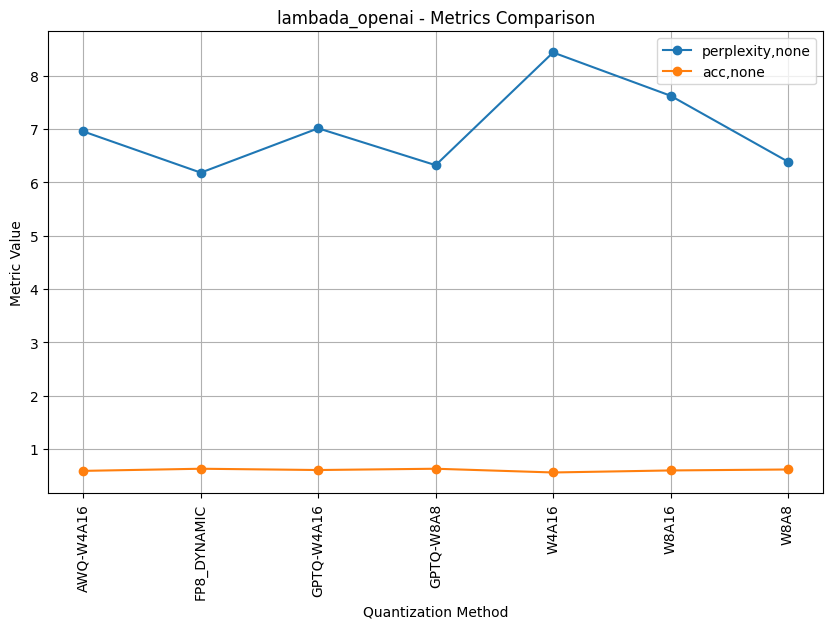

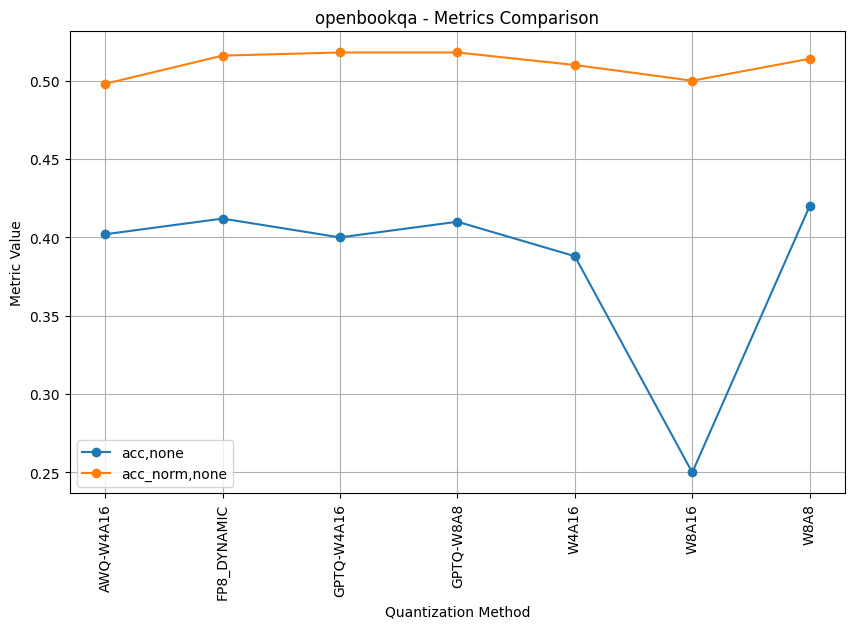

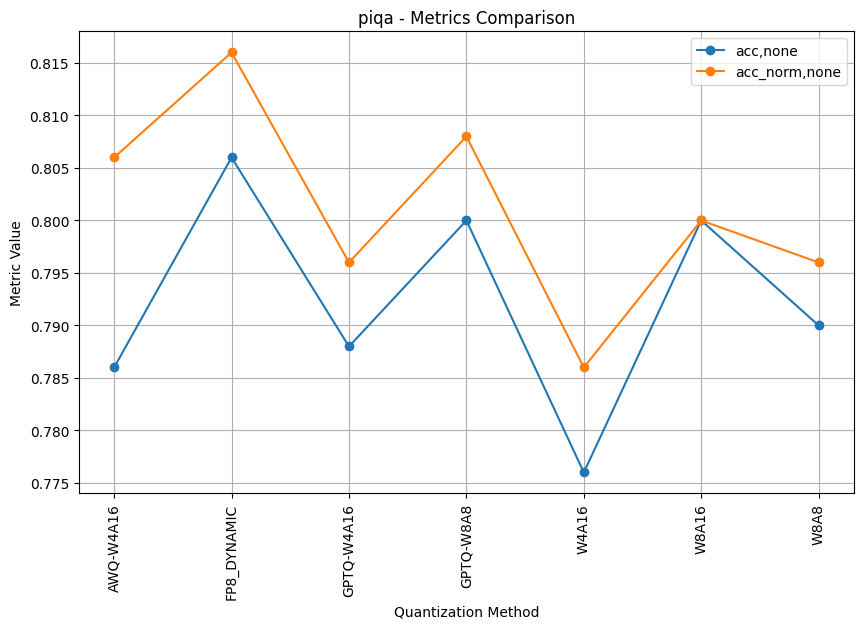

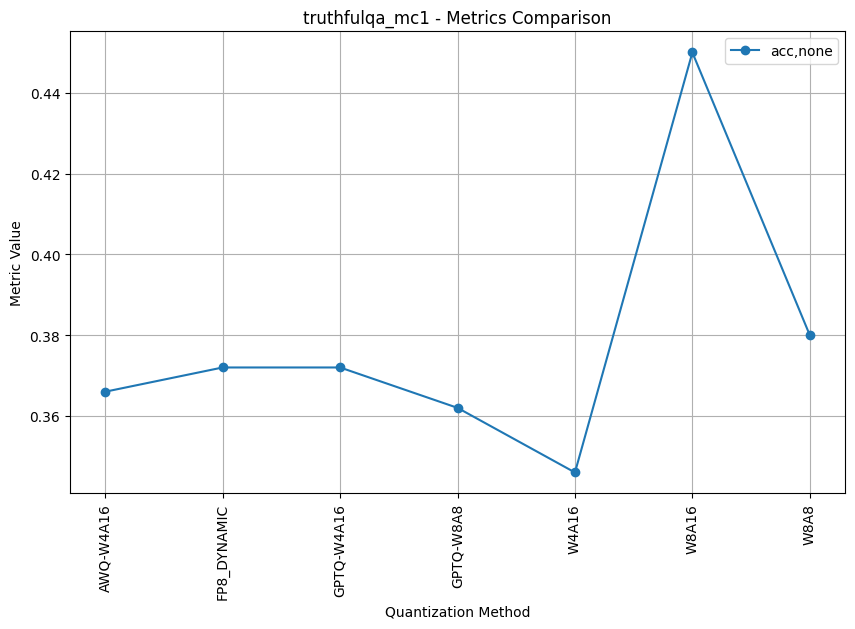

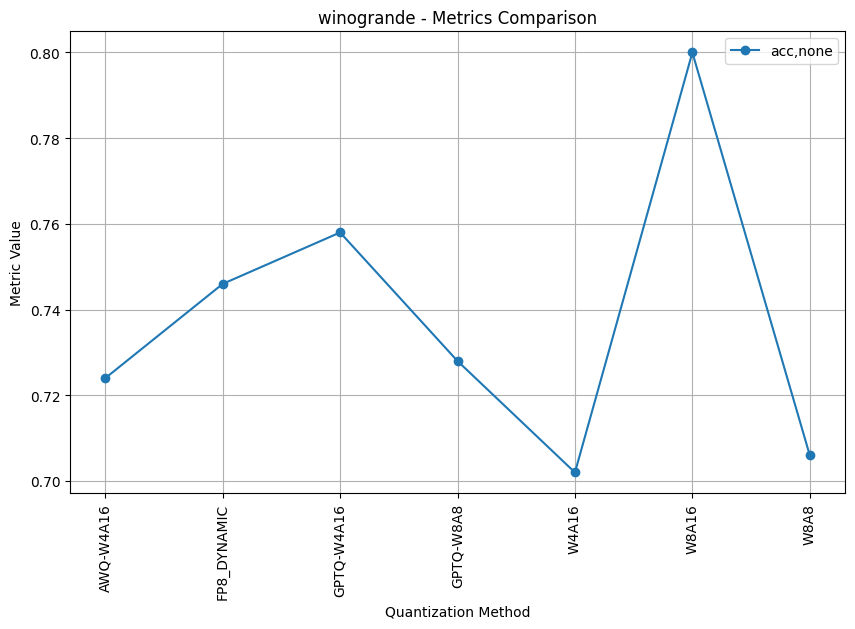

In [17]:
for task in task_list:
    plot_task_metrics(task)